In [7]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import traceback
from uuid import uuid4 as unique_identifier
import random
import os
from time import perf_counter
from glob import glob
import pandas as pd
from scipy.optimize import linear_sum_assignment

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm
from math import cos,sin

In [2]:
#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import maybetogray,maybetocolor, image_preprocess, canny, recenter
from aberrations import aberrations

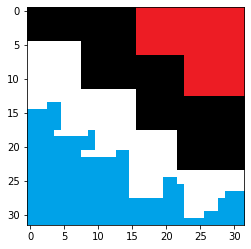

In [3]:
# load some test images
img_files=["stairtest.png","stairtest2.png","cornertest.png","cornertest2.png","cornertest3.png","cornertest4.png","tdl.png","tdl2.png","tokyo.png","tokyo2.png"]
test_images=[cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB) for iname in img_files]
plt.imshow(test_images[0])

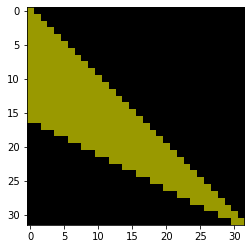

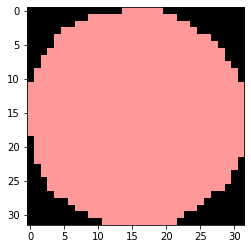

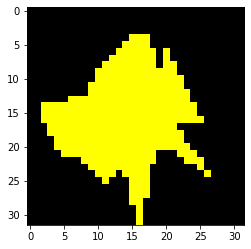

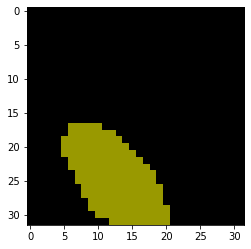

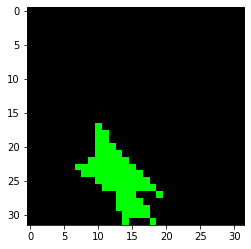

In [8]:
from PIL import Image, ImageDraw
def draw_poly(dc,poly, scale=1, **kwargs):
    coords = (poly*scale).astype(int)
    dc.polygon([tuple(i) for i in coords],**kwargs)
    def center(poly):
    return (poly - np.mean(poly,axis=0) + np.array([0.5, 0.5])).tolist()
def rescale(poly):
    p2 = poly - np.array([0.5,0.5])
    m = np.max(np.linalg.norm(p2,axis=1))
    p3 = p2*(0.7071067811865476/m)
    return (p3 + np.array([0.5,0.5])).tolist()
def generate_components(nums=[(5,4),(5,6),(5,8)], tonp=False):
    polys=[]
    for c,v in nums:
        for _ in range(c):
            p=[[0.5+cos(x*6.14/20)*np.random.uniform(0.2,1.0)/2,0.5+sin(x*6.14/20)*np.random.uniform(0.2,1.0)/2] for x in range(v)]
            p=center(p)
            p=rescale(p)
            polys.append(p)
    if tonp:
        return [np.array(i) for i in polys]
    return polys
polys=[# wedge
       [[0,0], [0,0.5], [1,1]],
       # circle
       [[0.5+cos(x*6.14/20)/2,0.5+sin(x*6.14/20)/2] for x in range(20)],
       # randomly perturbed circle
       [[0.5+cos(x*6.14/20)*np.random.uniform(0.2,1.0)/2,0.5+sin(x*6.14/20)*np.random.uniform(0.2,1.0)/2] for x in range(20)],
       # squished circle
       [[0.43889485, 1.01199527],
           [0.50584096, 1.03654858],
           [0.56339267, 1.03823472],
           [0.60616826, 1.01689601],
           [0.63016773, 0.97452786],
           [0.63314687, 0.91509216],
           [0.61482709, 0.8441468 ],
           [0.5769215 , 0.76832597],
           [0.52297469, 0.69471975],
           [0.45803129, 0.63021113],
           [0.38816421, 0.58083239],
           [0.31990682, 0.551201  ],
           [0.25964192, 0.5440878 ],
           [0.21300497, 0.56015797],
           [0.18435702, 0.59790877],
           [0.17637698, 0.65381007],
           [0.18981107, 0.72263449],
           [0.22340306, 0.79794618],
           [0.27401172, 0.87270266],
           [0.33690458, 0.93991338]],
      # star thing
      [[0.41807544, 0.87534801],
       [0.46415562, 0.98536887],
       [0.53947724, 0.94539019],
       [0.59524502, 1.0083861 ],
       [0.51879522, 0.89930979],
       [0.48691866, 0.83740086],
       [0.6054967 , 0.86355202],
       [0.58552607, 0.83129026],
       [0.41381491, 0.66344889],
       [0.4658818 , 0.68867009],
       [0.38576388, 0.62978679],
       [0.32330981, 0.55634607],
       [0.32094132, 0.70405591],
       [0.32852805, 0.70085152],
       [0.3041241 , 0.72073516],
       [0.28525641, 0.71508238],
       [0.22339421, 0.71973661],
       [0.35555229, 0.82499804],
       [0.33906122, 0.81146125],
       [0.38112243, 0.83347015]]]
polys=[np.array(p) for p in polys]
colors=[[255,255,255], #white
        [255,0,0], #red
        [0,255,0], #green
        [0,0,255], #blue
        [102,0,204], #purple
        [128,128,128], #gray
        [255,153,153], #pink
        [153,153,0], #puke green
        [102,102,0], #camo green
        [255,128,0], #orange
        [204,255,153], #light green
        [255,255,51], #lemon yellow
        [255,255,0], #yellow
       ]
for poly in polys:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

In [45]:
extrapolys = [np.array(i) for i in 
              [[[0.6418244038727151, 0.2998061868582428],
                [0.4686347285507535, 0.343719548648612],
                [0.538938997157498, 0.5484336730942655],
                [0.542681652704277, 0.450468227715067],
                [0.43109533978422987, 0.6070484675470792],
                [0.3768248779305259, 0.7505238961367339]],
               [[0.7551090088368116, 0.3251183354923094],
                [0.47828368692752177, 0.3965994485653471],
                [0.6092142376958286, 0.6016242032921474],
                [0.4316982732063379, 0.6707721033472805],
                [0.399862175097046, 0.5350890404631552],
                [0.32583261823645393, 0.4707968688397598]],
               [[0.515389669457967, 0.2818596661713876],
                [0.651050007044704, 0.35248958600744784],
                [0.5344039566627392, 0.35101235200083813],
                [0.5307715126552366, 0.6608543520782878],
                [0.458693432679527, 0.6142634014250895],
                [0.30969142149982576, 0.7395206423169486]],
               [[0.7159505013889395, 0.3009783869496805],
                [0.6637907407843163, 0.3318392884634721],
                [0.5505329020343993, 0.5764471642040447],
                [0.3955281025968944, 0.5022422023308493],
                [0.40290678721412976, 0.7070247292741323],
                [0.27129096598132074, 0.5814682287778206]],
               [[0.6622552572497098, 0.3531104710774633],
                [0.38125580389168034, 0.5008884838980432],
                [0.6275181515964631, 0.5421191321479667],
                [0.4713014681032167, 0.49403328856466466],
                [0.35766931915892997, 0.6098486243118619]],
               [[0.5418676102104842, 0.37277505232563524],
                [0.6375963533712182, 0.4244772677023234],
                [0.5879446917833321, 0.5361349301961581],
                [0.3760970022568636, 0.5168697665454319],
                [0.3564943423781022, 0.6497429832304513]],
               [[0.5929718054541705, 0.3881219851179716],
                [0.5759230333160092, 0.5126711736974675],
                [0.4044049510210801, 0.4795509972942713],
                [0.5330257440876567, 0.5622092012693746],
                [0.3936744661210836, 0.5574466426209147]],
               [[0.48541929309082743, 0.32768060751560224],
                [0.47509976114220076, 0.45643829870378894],
                [0.7294407587245033, 0.4392070096193348],
                [0.4230331213751821, 0.6618874068539375],
                [0.3870070656672866, 0.6147866773073363]],
               [[0.6609532006899512, 0.3344483978948014],
                [0.8713724436702532, 0.4829653192676955],
                [0.7012391375113879, 0.44445004499719365],
                [0.5530251550253507, 0.4646999329457697],
                [0.6019219974611618, 0.7010735186469367],
                [0.4789796152826973, 0.6631687044697621],
                [0.33835719580613455, 0.5480210762197315],
                [0.2927224597540182, 0.48237566698821976],
                [0.3701417391669003, 0.4783405644960057],
                [0.13128705563214438, 0.4004567740738836]],
               [[0.8577553339584751, 0.2976398314466867],
                [0.7691299309786327, 0.3947263351872622],
                [0.521913906804508, 0.5318671657174288],
                [0.6593530893331545, 0.5089094111359661],
                [0.5335649652336962, 0.6709952691519542],
                [0.44573133089511885, 0.5353144647279369],
                [0.3795276384266304, 0.4621699907853024],
                [0.26028436833773155, 0.5534893382165454],
                [0.26389690169644087, 0.6099680570978998],
                [0.30884253433561154, 0.43492013653301764]],
               [[0.629652104965897, 0.2725377037274951],
                [0.8592940610388403, 0.37215300166879084],
                [0.8457396167513952, 0.5102197374461156],
                [0.6179564771638816, 0.4414912523778187],
                [0.552246637268459, 0.486298727786322],
                [0.4507369637787937, 0.7439972130183611],
                [0.3517756933913417, 0.7142100367746026],
                [0.37172081455856637, 0.581360158283005],
                [0.17600917345280387, 0.5661104034064136],
                [0.14486845763002193, 0.31162176551107545]],
               [[0.8592291385847213, -0.007073882076366278],
                [0.4205544381889242, 0.1041549240920791],
                [0.5986291641232275, 0.6226783697942568],
                [0.6081089919340702, 0.37454023845952367],
                [0.32547036294262166, 0.771144653061714],
                [0.18800790422643376, 1.1345556966687935]],
               [[1.0832249154448208, 0.10018917222718754],
                [0.45035261626698864, 0.2636078077274028],
                [0.7496833210083366, 0.7323311420574868],
                [0.3438500113516152, 0.8904156344347808],
                [0.27106698533248264, 0.5802198352401366],
                [0.10182215059575572, 0.43323640831300414]],
               [[0.5355717627503136, -0.004210712414523976],
                [0.8491377789953641, 0.15904365496120598],
                [0.5795214859826296, 0.15562916852578668],
                [0.5711254358405786, 0.8717995935593092],
                [0.4045237835181016, 0.764109025709643],
                [0.060119752913011415, 1.0536292696585776]],
               [[1.0199651250159878, 0.020796213738760116],
                [0.894374972322895, 0.09510302206065374],
                [0.6216730063358995, 0.6840693077201152],
                [0.24845280356155963, 0.5053987696614392],
                [0.266219183564282, 0.9984736712629768],
                [-0.05068509080062378, 0.6961590155560536]],
               [[1.0242048722832013, 0.025437831391341814],
                [0.116368139865345, 0.5028704622345926],
                [0.9119782465263289, 0.6360760487059267],
                [0.4072824480225242, 0.4807230948387882],
                [0.040166293302600076, 0.8548925628293499]],
               [[0.6427394268533342, 0.06625142870139922],
                [0.9691078501633293, 0.24252001801935524],
                [0.7998302228581093, 0.6231949757737364],
                [0.07757696715069595, 0.5575141689659066],
                [0.010745532974532346, 1.0105194085396025]],
               [[0.9519327870910503, -0.043835228678793525],
                [0.86905928505201, 0.5615941447714934],
                [0.03531571527407856, 0.4005980927133018],
                [0.6605370197812045, 0.8023968134751911],
                [-0.016844807198342804, 0.7792461777188054]],
               [[0.45656302272993937, -0.013351895841667738],
                [0.4258203929327399, 0.37022655068539],
                [1.1835205647863394, 0.3188932979866185],
                [0.2707101186383115, 0.9822742584174604],
                [0.16338590091267047, 0.8419577887521982]],
               [[0.7980021241417895, 0.1934840135458975],
                [1.1875897875100285, 0.4684605772327403],
                [0.8725908536256859, 0.397150199462603],
                [0.5981751761553427, 0.43464252391741975],
                [0.6887068514947312, 0.8722842131041377],
                [0.46108111383196054, 0.8021040918541285],
                [0.20072108665426092, 0.5889102090279104],
                [0.11622914601632861, 0.4673688460274237],
                [0.25956963017984713, 0.45989792212746367],
                [-0.18266576960997583, 0.3156974037002747]],
               [[1.1154698475564726, 0.15186659633293959],
                [0.9630017832565122, 0.318890844429653],
                [0.537699923942721, 0.5548231647845655],
                [0.7741455187105986, 0.515327441391293],
                [0.5577440000881136, 0.7941743204031355],
                [0.4066380670512918, 0.560753778237628],
                [0.29274353454940705, 0.43491856642133986],
                [0.08760155538811704, 0.5920211991636021],
                [0.09381643227332254, 0.6891852249671329],
                [0.1711393371834431, 0.3880388638687108]],
               [[0.728053889922325, 0.0999011239404583],
                [1.131986717588962, 0.2751212346919143],
                [1.1081448852770195, 0.5179761900447706],
                [0.7074816561276258, 0.3970849914605572],
                [0.5919001574834968, 0.4758999020799869],
                [0.4133479009647735, 0.9291832637324311],
                [0.2392782036818044, 0.8767885770902218],
                [0.2743610314411695, 0.6431099062064272],
                [-0.06988946159163634, 0.6162860769991544],
                [-0.12466498089553912, 0.1686487337540783]]
              ]
             ]


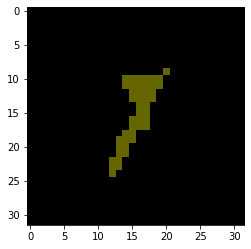

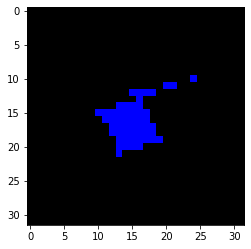

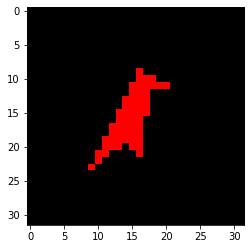

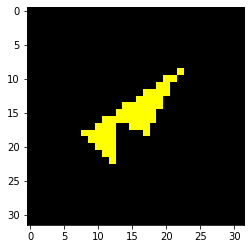

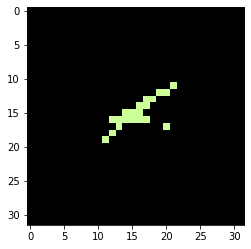

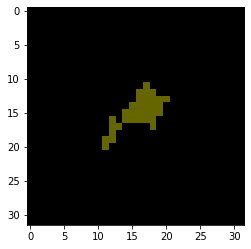

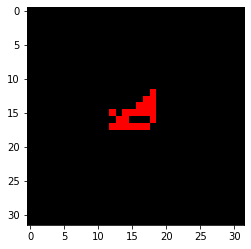

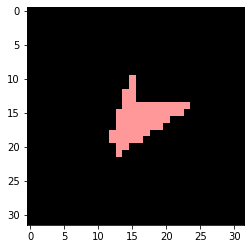

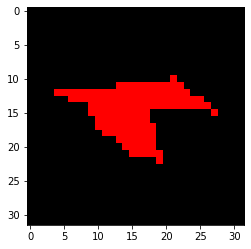

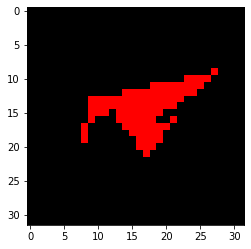

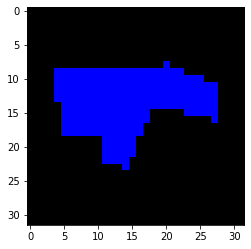

In [46]:
for poly in extrapolys:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

[[[0.8592291385847213, -0.007073882076366278],
  [0.4205544381889242, 0.1041549240920791],
  [0.5986291641232275, 0.6226783697942568],
  [0.6081089919340702, 0.37454023845952367],
  [0.32547036294262166, 0.771144653061714],
  [0.18800790422643376, 1.1345556966687935]],
 [[1.0832249154448208, 0.10018917222718754],
  [0.45035261626698864, 0.2636078077274028],
  [0.7496833210083366, 0.7323311420574868],
  [0.3438500113516152, 0.8904156344347808],
  [0.27106698533248264, 0.5802198352401366],
  [0.10182215059575572, 0.43323640831300414]],
 [[0.5355717627503136, -0.004210712414523976],
  [0.8491377789953641, 0.15904365496120598],
  [0.5795214859826296, 0.15562916852578668],
  [0.5711254358405786, 0.8717995935593092],
  [0.4045237835181016, 0.764109025709643],
  [0.060119752913011415, 1.0536292696585776]],
 [[1.0199651250159878, 0.020796213738760116],
  [0.894374972322895, 0.09510302206065374],
  [0.6216730063358995, 0.6840693077201152],
  [0.24845280356155963, 0.5053987696614392],
  [0.26621

In [60]:
ep2=[np.array(i) for i in
    []]

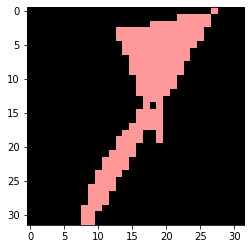

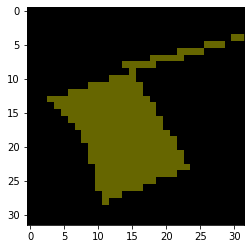

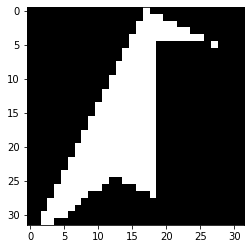

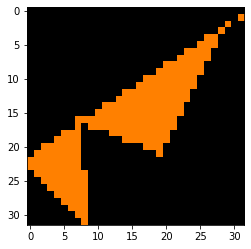

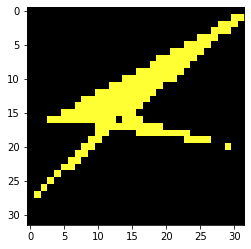

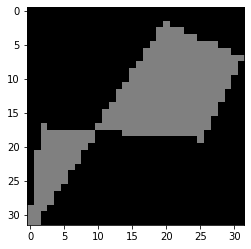

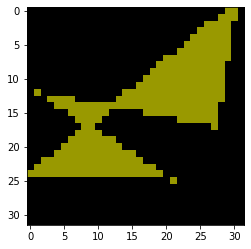

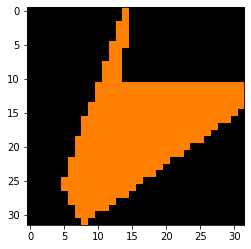

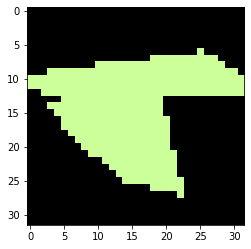

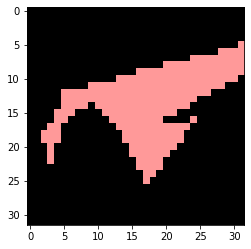

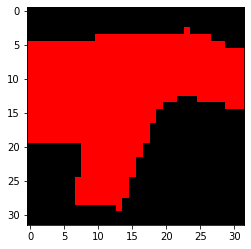

In [61]:
for poly in ep2:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

In [65]:
generate_components()

[array([[ 0.89888334, -0.04216091],
        [ 0.56576408,  0.28111057],
        [ 0.52858923,  0.75437725],
        [ 0.00676335,  1.00667308]]),
 array([[0.56456974, 0.01092062],
        [1.00892357, 0.14342165],
        [0.00290573, 0.64269032],
        [0.42360095, 1.20296741]]),
 array([[ 0.36255677, -0.15119398],
        [ 1.07522328,  0.77728989],
        [ 0.6540629 ,  0.48696493],
        [-0.09184295,  0.88693917]]),
 array([[ 0.84986438,  0.22849654],
        [ 0.7349652 ,  0.35923745],
        [ 0.61880714,  0.84229912],
        [-0.20363672,  0.56996689]]),
 array([[ 0.07988453, -0.06877324],
        [ 0.58222672,  0.44170609],
        [ 0.76457935,  1.04018634],
        [ 0.57330939,  0.58688081]]),
 array([[ 0.97106416, -0.0273505 ],
        [ 0.81150137,  0.06556497],
        [ 0.35594565,  0.55290855],
        [ 0.52849516,  0.69614957],
        [ 0.30774389,  0.94373455],
        [ 0.02524977,  0.76899287]]),
 array([[0.49186693, 0.16584314],
        [0.93550076, 0.304